# 点群データをJupyterでグリグリ

# point cloud processing


In [1]:
# 必要なモジュールを読み込む
import glob
import io
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import json
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pdal
import PIL
import pyproj
import requests
import shapely.geometry
import scipy.spatial
import sys
import urllib.request

In [2]:
%load_ext autoreload
%autoreload 2
    
sys.path.append('../src')
from pcl_utils import local_max

%matplotlib inline

In [3]:
# ファイルを確認する
mms_filename = 'MMS_subsample.las'
if not os.path.isfile('../data/' + mms_filename):
    print("No Data")

In [ ]:
# 大手町周辺の地図を表示し、範囲を選択
m = ipyleaflet.Map(center=(35.685751, 139.761228), zoom=17)
dc = ipyleaflet.DrawControl()
m.add_control(dc)
m

## Selecting street portion with a polygon
![](../img/leaflet.png)

POLYGON ((-6558.26632205265 -34849.17662094436, -6501.885428214457 -34859.31377348999, -6519.861278309005 -34933.85374847946, -6566.632001946517 -34901.53515337567, -6558.26632205265 -34849.17662094436))


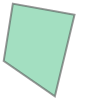

In [7]:
#　選択した範囲のポリゴン 
wsg84 = pyproj.Proj(init='epsg:4326')
lambert = pyproj.Proj(init='epsg:2451')
coords = [pyproj.transform(wsg84,lambert,x,y) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
polygon = shapely.geometry.Polygon(coords)
print(polygon.wkt)
IPython.display.display(polygon)

In [8]:
# 点群データから、選択ポリゴンの点群を抽出する
b = polygon.bounds
cropper = {
    "pipeline": [ '../data/'+ mms_filename,
        {   "type":"filters.crop",
            'bounds':str(([b[0], b[2]],[b[1], b[3]]))},
        {   "type":"filters.hag"}
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon.area))

CPU times: user 3.18 s, sys: 124 ms, total: 3.3 s
Wall time: 3.34 s
Pipeline selected 901218 points (253.7 pts/m2)


In [9]:
# Load Pipeline output in python objects
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']
df['X'] = df['X'] - df['X_0'].min()
df['Y'] = df['Y'] - df['Y_0'].min()
df['Z'] = df['Z'] - df['Z_0'].min()

In [ ]:
# 抽出した点群を表示する
fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(df['Y'], df['Z'], df['X'], color='red', size=.2)
p3.squarelim()
p3.show()

## Original data
![](../img/img00.png)

In [12]:
#抽出した点群データの中身を確認
df.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue,HeightAboveGround,X_0,Y_0,Z_0
0,0.104,13.840,10.784,21320,0,0,0,0,2,0.0,10,60,197517.070882,0,0,0,0.0,-6566.52225,-34920.006991,2.779999
1,0.224,13.840,10.784,17585,0,0,0,0,2,0.0,10,60,197517.070882,0,0,0,0.0,-6566.40225,-34920.006991,2.779999
2,0.336,13.840,10.792,21353,0,0,0,0,2,0.0,10,60,197517.070882,0,0,0,0.0,-6566.29025,-34920.006991,2.787999
3,0.440,13.848,10.792,19060,0,0,0,0,2,0.0,10,60,197517.070882,0,0,0,0.0,-6566.18625,-34919.998991,2.787999
4,0.552,13.840,10.792,20616,0,0,0,0,2,0.0,10,60,197517.070882,0,0,0,0.0,-6566.07425,-34920.006991,2.787999


In [13]:
# Classification を集計カウントする
df['Classification'].value_counts()

2     340700
10    299767
6     259758
0        968
7         25
Name: Classification, dtype: int64

**［LAS分類コード］**  
American Society for Photogrammetry and Remote Sensing（ASPRS）によって定義されたLAS分類コード

|分類値|意味|
|:---:|:---|
|0|分類不可|
|1|未分類|
|2|地表|
|3|低植生|
|4|中植生|
|5|高植生|
|6|建物|
|7|低点|
|8|予約済み|
|9|水域|
|10|レール|
|11|路面|
|12|予約済み|
|13|保護線（シールド）|
|14|導線（フェーズ）|
|15|送電塔|
|16|ワイヤ構造コネクタ（絶縁体）|
|17|橋床版|
|18|高ノイズ|
|19-63|予約済み|
|64-255|ユーザ定義可能|

LAS 1.4 https://www.asprs.org/wp-content/uploads/2010/12/LAS_1-4_R6.pdf

In [14]:
df['NumberOfReturns'].value_counts()

0    901218
Name: NumberOfReturns, dtype: int64

In [15]:
# ground と それ以外に分けて、それぞれ定義する
df['ground'] = df['Classification']==2

ground = p3.scatter(df.loc[df['ground'],'Y'].values, df.loc[df['ground'],'Z'].values, df.loc[df['ground'],'X'].values, color='red', size=.2)
non_ground = p3.scatter(df.loc[~df['ground'],'Y'].values, df.loc[~df['ground'],'Z'].values, df.loc[~df['ground'],'X'].values, color='red', size=.2)

In [16]:
# ground とそれ以外を可視化する。ground はグレー。
fig.scatters.append(ground)
fig.scatters.append(non_ground)
all_points.visible = False
ground.color='lightgrey'


## Use gound / non-ground classification
![](../img/img01.png)

In [ ]:
# groundをサーフェス生成
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False

In [ ]:
p3.show()

## non-ground surface
![](../img/img02.png)